In [1]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [3]:
import numpy as np
a = np.array([[1,2,3],[3,4,5]])
print(a)
print(a[-1:])

[[1 2 3]
 [3 4 5]]
[[3 4 5]]


In [4]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install scipy==1.1.0

Note: you may need to restart the kernel to use updated packages.


In [1]:
# read images and steering angles from driving_dataset folder

from __future__ import division

import os
import numpy as np
import random

from scipy import pi
from itertools import islice



DATA_FOLDER = 'driving_dataset' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7
y = []
X=[]
with open(TRAIN_FILE) as fp:
    for line in islice(fp,None,None):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        #converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )

y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]

          

Completed processing data.txt


C:\Users\kotte\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
C:\Users\kotte\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


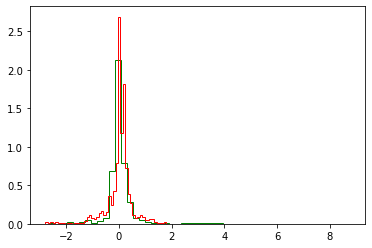

In [3]:
import numpy;

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()




## Building a simple base line model

In [4]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


## Performing train&val split and creating batches

In [5]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out


In [6]:
# scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0
# you can break the whole line into parts like this
# here (train_batch_pointer + i) % num_train_images => "% num_train_images" is used to make sure that the
# (train_batch_pointer + i) values should not cross number of train images.
import scipy.misc
#import matplotlib.pyplot
#import imageio
#from matplotlib.pyplot import imread
# lets explain whats happening with the first images
image_read = scipy.misc.imread(train_xs[0])
print("original image size",image_read.shape)

print("After taking the last 150 rows i.e lower part of the images where road is present, ",image_read[-150:].shape)
image_read = image_read[-150:]
resized_image = scipy.misc.imresize(image_read, [66, 200])
print("After resizing the images into 66*200, ",resized_image.shape)
# 200/66 = 455/150 = 3.0303 => we are keeping aspect ratio when we are resizing it

original image size (256, 455, 3)
After taking the last 150 rows i.e lower part of the images where road is present,  (150, 455, 3)
After resizing the images into 66*200,  (66, 200, 3)


C:\Users\kotte\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kotte\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


In [7]:
scipy.misc.imresize(scipy.misc.imread(train_xs[0])[-150:], [66, 200])

C:\Users\kotte\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\kotte\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


array([[[178, 163, 165],
        [175, 172, 172],
        [176, 175, 171],
        ...,
        [ 89,  89, 109],
        [104,  95, 100],
        [101, 102,  87]],

       [[191, 187, 192],
        [186, 192, 202],
        [188, 195, 200],
        ...,
        [ 84,  84,  92],
        [ 86,  87,  80],
        [ 88,  99,  77]],

       [[207, 203, 221],
        [201, 212, 229],
        [202, 212, 228],
        ...,
        [127, 124, 116],
        [128, 126, 119],
        [130, 126, 120]],

       ...,

       [[ 55,  43,  54],
        [ 59,  43,  56],
        [ 55,  41,  54],
        ...,
        [ 23,  24,  24],
        [ 24,  25,  27],
        [ 25,  26,  28]],

       [[ 57,  36,  55],
        [ 53,  35,  59],
        [ 51,  39,  53],
        ...,
        [ 23,  24,  22],
        [ 24,  25,  24],
        [ 24,  27,  26]],

       [[ 65,  38,  45],
        [ 54,  41,  48],
        [ 50,  47,  41],
        ...,
        [ 27,  25,  25],
        [ 26,  23,  25],
        [ 24,  22,  24]]

In [8]:
xs

['driving_dataset/0.jpg',
 'driving_dataset/1.jpg',
 'driving_dataset/2.jpg',
 'driving_dataset/3.jpg',
 'driving_dataset/4.jpg',
 'driving_dataset/5.jpg',
 'driving_dataset/6.jpg',
 'driving_dataset/7.jpg',
 'driving_dataset/8.jpg',
 'driving_dataset/9.jpg',
 'driving_dataset/10.jpg',
 'driving_dataset/11.jpg',
 'driving_dataset/12.jpg',
 'driving_dataset/13.jpg',
 'driving_dataset/14.jpg',
 'driving_dataset/15.jpg',
 'driving_dataset/16.jpg',
 'driving_dataset/17.jpg',
 'driving_dataset/18.jpg',
 'driving_dataset/19.jpg',
 'driving_dataset/20.jpg',
 'driving_dataset/21.jpg',
 'driving_dataset/22.jpg',
 'driving_dataset/23.jpg',
 'driving_dataset/24.jpg',
 'driving_dataset/25.jpg',
 'driving_dataset/26.jpg',
 'driving_dataset/27.jpg',
 'driving_dataset/28.jpg',
 'driving_dataset/29.jpg',
 'driving_dataset/30.jpg',
 'driving_dataset/31.jpg',
 'driving_dataset/32.jpg',
 'driving_dataset/33.jpg',
 'driving_dataset/34.jpg',
 'driving_dataset/35.jpg',
 'driving_dataset/36.jpg',
 'driving_d

In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Architecture of  End -to- End CNN model

In [10]:
#import tensorflow as tf
import scipy

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.elu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.elu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.elu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.elu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.elu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.elu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.elu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.elu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.elu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.identity(tf.matmul(h_fc4_drop, W_fc5)) + b_fc5 #scale the atan output


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Training the CNN model

In [11]:
import os
#import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
#import model

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [12]:
epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
    for i in range(int(driving_data.num_images/batch_size)):
        xs, ys = driving_data.LoadTrainBatch(batch_size)
        train_step.run(feed_dict={x: xs, y_: ys, keep_prob: 0.5})
        if i % 10 == 0:
            xs, ys = driving_data.LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
        summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
    print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

Epoch: 0, Step: 0, Loss: 6.33594
Epoch: 0, Step: 10, Loss: 6.87806
Epoch: 0, Step: 20, Loss: 6.31275
Epoch: 0, Step: 30, Loss: 6.21225
Epoch: 0, Step: 40, Loss: 6.16965
Epoch: 0, Step: 50, Loss: 6.18967
Epoch: 0, Step: 60, Loss: 6.31575
Epoch: 0, Step: 70, Loss: 7.02636
Epoch: 0, Step: 80, Loss: 7.74496
Epoch: 0, Step: 90, Loss: 6.34098
Epoch: 0, Step: 100, Loss: 6.19772
Epoch: 0, Step: 110, Loss: 6.11858
Epoch: 0, Step: 120, Loss: 6.11993
Epoch: 0, Step: 130, Loss: 6.11759
Epoch: 0, Step: 140, Loss: 6.1218
Epoch: 0, Step: 150, Loss: 6.1851
Epoch: 0, Step: 160, Loss: 6.14956
Epoch: 0, Step: 170, Loss: 6.08864
Epoch: 0, Step: 180, Loss: 6.19279
Epoch: 0, Step: 190, Loss: 6.48326
Epoch: 0, Step: 200, Loss: 6.15227
Epoch: 0, Step: 210, Loss: 6.22002
Epoch: 0, Step: 220, Loss: 6.05459
Epoch: 0, Step: 230, Loss: 6.04792
Epoch: 0, Step: 240, Loss: 6.04198
Epoch: 0, Step: 250, Loss: 6.04001
Epoch: 0, Step: 260, Loss: 6.05334
Epoch: 0, Step: 270, Loss: 10.5265
Epoch: 0, Step: 280, Loss: 6.7833

In [35]:
pip install opencv-python

  Using cached opencv_python-4.2.0.32-cp37-cp37m-win_amd64.whl (33.0 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\kotte\\Anaconda3\\envs\\tf-gpu\\Lib\\site-packages\\cv2\\cv2.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



## Test and visualizing the CNN model

In [15]:
#pip3 install opencv-python

#import tensorflow as tf
import scipy.misc
#import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q') and i<len(ys)):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = y.eval(feed_dict={x: [image],keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


INFO:tensorflow:Restoring parameters from save/model.ckpt
Starting frameofvideo:31785
Steering angle: -7.212506447483276 (pred)	-28.34 (actual)
Steering angle: -9.147190827061591 (pred)	-28.840000000000003 (actual)
Steering angle: -7.789684753106034 (pred)	-29.75 (actual)
Steering angle: -4.385104390553247 (pred)	-31.06 (actual)
Steering angle: -4.377611673033742 (pred)	-32.27 (actual)
Steering angle: -3.6471477007366198 (pred)	-33.48 (actual)
Steering angle: -4.430867511765978 (pred)	-34.39 (actual)
Steering angle: -5.109139447294094 (pred)	-35.599999999999994 (actual)
Steering angle: -5.104303673361725 (pred)	-36.5 (actual)


C:\Users\kotte\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\kotte\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: -5.7829666372198245 (pred)	-37.61 (actual)
Steering angle: -5.890467838340301 (pred)	-38.62 (actual)
Steering angle: -5.8334801550003 (pred)	-39.63 (actual)
Steering angle: -5.120243627337243 (pred)	-39.93000000000001 (actual)
Steering angle: -4.815367034676322 (pred)	-40.03000000000001 (actual)
Steering angle: -4.72323461296202 (pred)	-40.03000000000001 (actual)
Steering angle: -4.3362932974233965 (pred)	-40.03000000000001 (actual)
Steering angle: -4.317313055493577 (pred)	-40.03000000000001 (actual)
Steering angle: -3.625989482235213 (pred)	-40.03000000000001 (actual)
Steering angle: -2.043689502976665 (pred)	-40.03000000000001 (actual)
Steering angle: -2.744901909492738 (pred)	-40.03000000000001 (actual)
Steering angle: -2.0430248401930577 (pred)	-40.03000000000001 (actual)
Steering angle: -2.5430160317791475 (pred)	-40.24 (actual)
Steering angle: -3.879596113665079 (pred)	-40.93999999999999 (actual)
Steering angle: 2.010972683408892 (pred)	-41.14 (actual)
Steering a